In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce, einsum
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor

In [2]:
x = torch.rand(2,224,224,3)

In [3]:
x = rearrange(x,'b h w c -> b c h w')
x.shape

torch.Size([2, 3, 224, 224])

In [4]:
x = torch.rand(128)
print(x.shape)
x = rearrange(x,'(i j) -> i j',i=64,j=2)
x.shape

torch.Size([128])


torch.Size([64, 2])

In [5]:
x = torch.rand(32,32)
print(x.shape)
x = rearrange(x,'i j -> (i j)')
x.shape

torch.Size([32, 32])


torch.Size([1024])

# Creating ViT patches

[source](https://github.com/lucidrains/x-transformers/blob/1cfead36ab650e3c2af07a8a552c50a200c927cd/x_transformers/x_transformers.py#L1251C13-L1251C13)

In [6]:
im_size = 224
patch_size = 16
num_patches = (im_size // patch_size) ** 2
print(num_patches)

x = torch.rand(1,3,im_size,im_size)
x = rearrange(x,'b c (h p1) (w p2) -> b (h w) c p1 p2',p1=patch_size,p2=patch_size)
x.shape, x.shape[1] == num_patches

196


(torch.Size([1, 196, 3, 16, 16]), True)

torch.Size([3, 224, 224])


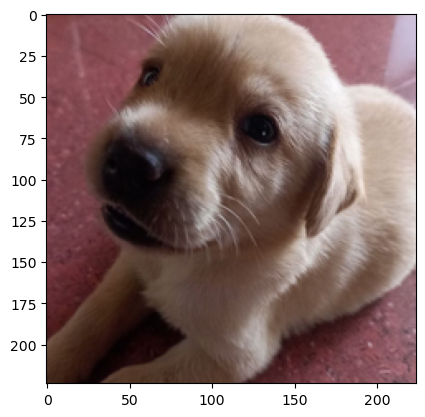

In [152]:
im = Image.open('./sumo.jpg').convert('RGB').resize((224,224))
im = to_tensor(im)
print(im.shape)
plt.imshow(im.permute(1,2,0))

In [153]:
patches = rearrange(im,'c (h p1) (w p2) -> (h w) c p1 p2',p1=patch_size,p2=patch_size)
patches.shape

torch.Size([196, 3, 16, 16])

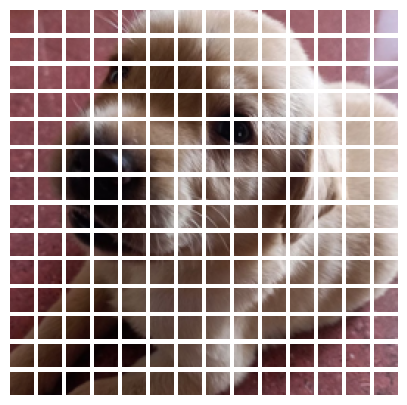

In [146]:
figure = plt.figure(figsize=(5,5))
for i in range(patches.size(0)):
    img = patches[i].permute(1,2,0)
    figure.add_subplot(14,14,i+1)
    plt.axis('off')
    plt.imshow(img)
    
plt.show()

# Self-Attention Mechanism

## single head attention

In [105]:
EMBED_DIM = 32
N_HEADS = 1
HEAD_SIZE = EMBED_DIM // N_HEADS
SEQ_LEN = 8

In [106]:
class Attention(nn.Module):
    def __init__(self,):
        """
        attention(q,k,v) = softmax[(qk')/sqrt(k_dim)]v 
        scale = 1/sqrt(k_dim)
        attention(q,k,v) = softmax(qk'*scale)v
        """
        super().__init__()
        self.embed_dim = EMBED_DIM
        self.head_size = HEAD_SIZE
        self.seq_len = SEQ_LEN
        
        self.query = nn.Linear(self.embed_dim, self.head_size,bias=False)
        self.key = nn.Linear(self.embed_dim, self.head_size, bias=False)
        self.value = nn.Linear(self.embed_dim,self.head_size,bias=False)
        
        self.scale = self.head_size ** -0.5
        
        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.seq_len,self.seq_len))
        )
        
        self.attn_dropout = nn.Dropout(0.)
        
    def forward(self,x):
        b,t,c = x.shape # batch_size, seq_len, n_embed
        
        q = self.query(x) # b, t, head_size
        k = self.key(x) # b, t, head_size
        v = self.value(x) # b, t, head_size
        
        # k_t: b, head_size, t
        # q @ k_t = b, t, t
        qk_t = einsum(q,k,'b t1 h, b t2 h -> b t1 t2') * self.scale # order of t1, t2 is important.
        
        weights = qk_t.masked_fill(self.tril==0,float('-inf'))
        weights = F.softmax(weights,dim=1)
        
        weights = self.attn_dropout(weights)
        
        # weights: b,t,t v: b,t,head_size
        att = weights @ v
        
        return att # b,t,head_size
    
x = torch.rand(16,SEQ_LEN,EMBED_DIM)
a = Attention()
a1 = a(x)
a1.shape

torch.Size([16, 8, 32])

In [107]:
x = torch.rand(16,SEQ_LEN,EMBED_DIM)
y = torch.rand(16,SEQ_LEN,EMBED_DIM)
x.shape, y.shape
(x@y.mT).shape

torch.Size([16, 8, 8])

In [20]:
y.shape, y.transpose(-2,-1).shape

(torch.Size([16, 8, 32]), torch.Size([16, 32, 8]))

In [32]:
xyT = torch.einsum('b t h,b T h->b t T',[x,y])
xyT2 = torch.einsum('b t h,b T h->b T t',[x,y])
torch.unique(xyT==xyT2), torch.unique(x@y.mT==xyT), torch.unique(x@y.mT==xyT2)

(tensor([False,  True]), tensor([True]), tensor([False,  True]))

In [27]:
xyT2 = einsum(x,y,'b t1 h, b t2 h->b t1 t2')

In [29]:
np.unique(xyT == xyT2)

array([ True])

## Multi Head Attention

- single attention head output: batch x seq_len x head_size
- multi head attention output: batch x seq_len x embed_dim
- since embed_dim = head_size x n_heads
- and multiple single attention heads are concat-ed along head_size dim, we get embed_dim again
- hence we calculate key,query,value for all the heads at once
- and since we need to get 3 vectors: k,q,v, we do embed_dim * 3 and then chunk them into 3 parts, k,q and v.

In [108]:
EMBED_DIM = 64
N_HEADS = 4
HEAD_SIZE = EMBED_DIM // N_HEADS
SEQ_LEN = 32
EMBED_DIM, N_HEADS, HEAD_SIZE, SEQ_LEN

(64, 4, 16, 32)

In [ ]:
"""
inner_dim = dim x num_heads
          = 64 x 4
          = 256
"""

In [156]:
class MultiHeadAttention(nn.Module):
    def __init__(self,):
        super().__init__()
        self.embed_dim = EMBED_DIM
        self.n_heads = N_HEADS
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = SEQ_LEN
        
        self.qkv = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=False)
        
        self.scale = self.head_size ** -0.5
        
        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.seq_len,self.seq_len))
        )
        
        self.attn_dropout = nn.Dropout(0.)
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.qkv(x).chunk(3,dim=-1)
        q = rearrange(q,'b t (h n) -> b n t h',n=self.n_heads) # h = head_size
        k = rearrange(k,'b t (h n) -> b n t h',n=self.n_heads)
        v = rearrange(v,'b t (h n) -> b n t h',n=self.n_heads)
        
        qk_t = einsum(q,k,'b n t1 h, b n t2 h -> b n t1 t2') * self.scale
        
        weights = qk_t.masked_fill(self.tril==0,float('-inf'))
        weights = F.softmax(weights,dim=-1)
        
        weights = self.attn_dropout(weights)
        
        attention = weights @ v # batch x n_heads x seq_len x head_size
        attention = rearrange(attention,'b n t h -> b t (n h)')
        
        return attention

In [155]:
x = torch.rand(16,SEQ_LEN,EMBED_DIM)
a = MultiHeadAttention()
out = a(x)
out.shape

torch.Size([16, 32, 64])